In [101]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import os
import matplotlib.pyplot as plt

# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
#       see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [91]:
pretrained_model = "data/lenet_mnist_model.pth"
use_cuda=False

In [92]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, download=False, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the network
model = Net().to(device)
loss_fn = nn.CrossEntropyLoss(reduction='sum')

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

CUDA Available:  False


<All keys matched successfully>

In [123]:
def test(model, device, epoch, epsilon, alpha ):
    # Accuracy counter
    benign_loss = 0
    adv_loss = 0
    benign_correct = 0
    adv_correct = 0
    total = 0
    adv_examples = []
    print('\n[ Test epoch: %d ]' % epoch)
    model.eval()
    # Loop over all examples in test set
    for idx, (data, target) in enumerate(test_loader):

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        total += target.size(0)
        # Forward pass the data through the model
        output = model(data)
        loss = loss_fn(output, target)
        benign_loss += loss.item()
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        benign_correct += init_pred.eq(target).sum().item()
        

        if idx % 1000 == 0:
            print('\nCurrent batch:', str(idx))
            print('Current benign test accuracy:', str(benign_correct / target.size(0)))
            print('Current benign test loss:', benign_loss)

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue
        
        # Call Random Attack
        perturbed_data = perturb_new(epsilon, alpha, data, target)
        # Re-classify the perturbed image
        output = model(perturbed_data)
        # Check for success
        loss = loss_fn(output, target)
        adv_loss += loss.item()

        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        adv_correct += final_pred.eq(target).sum().item()
        
        if final_pred.item() == target.item():
            adv_correct += 1
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        
        if idx % 1000 == 0:
            print('Current adversarial test accuracy:', str(final_pred.eq(target).sum().item() / target.size(0)))
            print('Current adversarial test loss:', loss.item())

    
    print('\nTotal benign test accuarcy:', 100. * benign_correct / total)
    print('Total adversarial test Accuarcy:', 100. * adv_correct / total)
    print('Total benign test loss:', benign_loss)
    print('Total adversarial test loss:', adv_loss)

    correct = adv_correct+benign_correct
    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tAlpha: {alpha}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")
    
    state = {
        'net': model.state_dict()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved!')
    
    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [21]:
from torch.nn.functional import normalize
from torch.autograd import Variable

iters = 5
def perturb_new(epsilon, alpha_star,data,target):
    np.random.seed(42)
    delta_ = normalize(torch.FloatTensor(np.random.uniform(-epsilon,epsilon,data.shape)))
    data_adv = data + delta_ 
    for i in range(iters):
        X_var = Variable(data_adv, requires_grad=True)
        y_var = Variable(torch.LongTensor(target))

        scores = model(X_var)
        loss = loss_fn(scores, y_var)
        loss.backward()

        grad = X_var.grad.data.cpu()


        data_adv = np.array(data_adv) + (1/(i+1)) * np.array(np.sign(grad))

        data_adv = np.clip(data_adv, data - (epsilon*alpha_star - 1), data + (epsilon*alpha_star - 1))
        data_adv = np.clip(data_adv, 0, 1) # ensure valid pixel range
    return data_adv

In [34]:
def testing_samples(eps_alp):
    accuracies = []
    examples = []
    # Run test for each epsilon
    for epoch,(eps, alp) in enumerate(eps_alp):
        acc, ex = test(model, device,epoch, eps, alp)
        accuracies.append(acc)
        examples.append(ex)
    return accuracies,examples

In [99]:
def sample_viewer(examples,eps_alp):
    cnt = 0
    plt.figure(figsize=(5*len(eps_alp)/2,len(eps_alp)*2))
    for i in range(len(eps_alp)):
        for j in range(len(examples[i])):
            ex = examples[i]
            cnt += 1
            plt.subplot(len(eps_alp),len(examples[0]),cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel(f"Eps: {eps_alp[i][0]},alpha: {eps_alp[i][1]}", fontsize=14)
            adv = ex[j][2]
            plt.title(f"{ex[j][0]}->{ex[j][1]}")
            plt.imshow(adv, cmap="gray")
    plt.tight_layout()
    plt.show()

## Epsilon = 0.3

In [70]:
eps_alp_03 = [(0.3, 1),(0.3,0.1),(0.3,0.01)]
acc_03,examples_03 = testing_samples(eps_alp_03)

Epsilon: 0.3	Alpha: 1	Test Accuracy = 8936 / 10000 = 0.8936
Epsilon: 0.3	Alpha: 0.1	Test Accuracy = 964 / 10000 = 0.0964
Epsilon: 0.3	Alpha: 0.01	Test Accuracy = 964 / 10000 = 0.0964


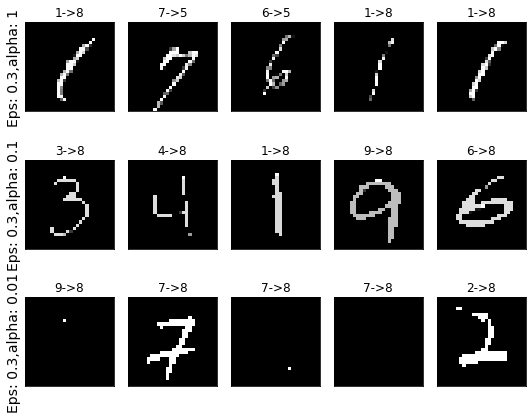

In [71]:
sample_viewer(examples_03,eps_alp_03)

## Epsilon = 1

In [72]:
eps_alp_1 = [(1,0.01),(1, 0.05),(1,0.1),(1,5),(1,0.5)]
acc_1,examples_1 = testing_samples(eps_alp_1)

Epsilon: 1	Alpha: 0.01	Test Accuracy = 964 / 10000 = 0.0964
Epsilon: 1	Alpha: 0.05	Test Accuracy = 972 / 10000 = 0.0972
Epsilon: 1	Alpha: 0.1	Test Accuracy = 2003 / 10000 = 0.2003
Epsilon: 1	Alpha: 5	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 1	Alpha: 0.5	Test Accuracy = 9644 / 10000 = 0.9644


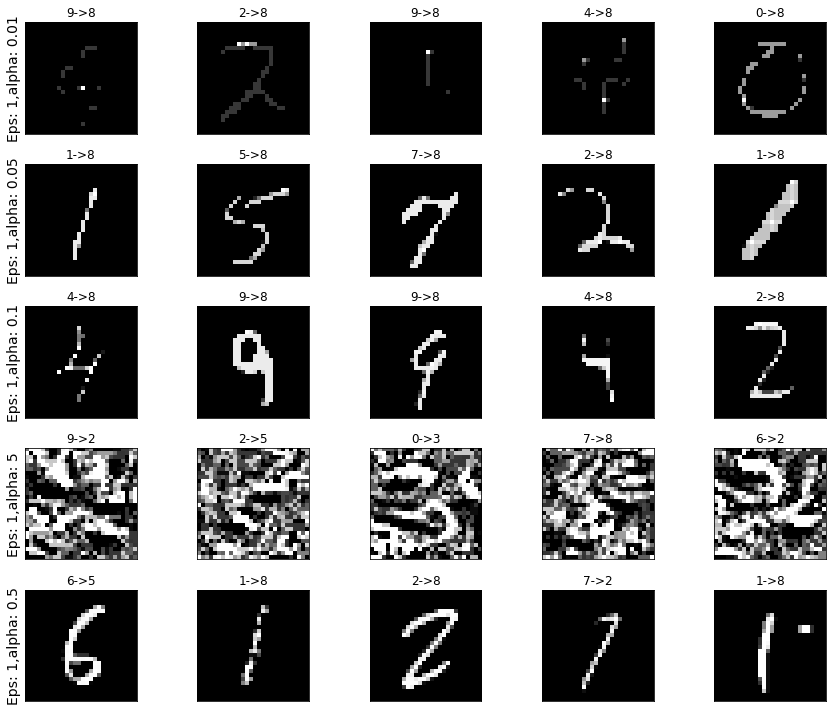

In [73]:
sample_viewer(examples_1,eps_alp_1)

## Epsilon = 0.7

In [74]:
eps_alp_07 = [(0.7,4),(0.7,0.04),(0.7,0.4),(0.7,14),(0.7,0.004)]
acc_07,examples_07 = testing_samples(eps_alp_07)

Epsilon: 0.7	Alpha: 4	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.7	Alpha: 0.04	Test Accuracy = 964 / 10000 = 0.0964
Epsilon: 0.7	Alpha: 0.4	Test Accuracy = 8713 / 10000 = 0.8713
Epsilon: 0.7	Alpha: 14	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.7	Alpha: 0.004	Test Accuracy = 964 / 10000 = 0.0964


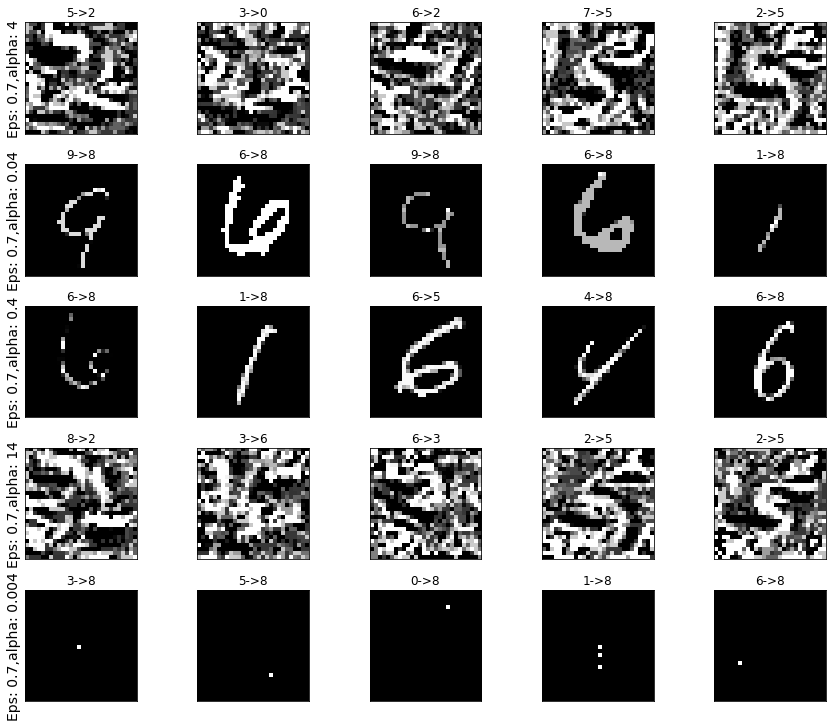

In [75]:
sample_viewer(examples_07,eps_alp_07)

## Epsilon = 0.05

In [76]:
eps_alp_005 = [(0.05,0.2),(0.05,0.02),(0.05,0.002),(0.05,2)]
acc_005,examples_005 = testing_samples(eps_alp_005)

Epsilon: 0.05	Alpha: 0.2	Test Accuracy = 964 / 10000 = 0.0964
Epsilon: 0.05	Alpha: 0.02	Test Accuracy = 964 / 10000 = 0.0964
Epsilon: 0.05	Alpha: 0.002	Test Accuracy = 964 / 10000 = 0.0964
Epsilon: 0.05	Alpha: 2	Test Accuracy = 2003 / 10000 = 0.2003


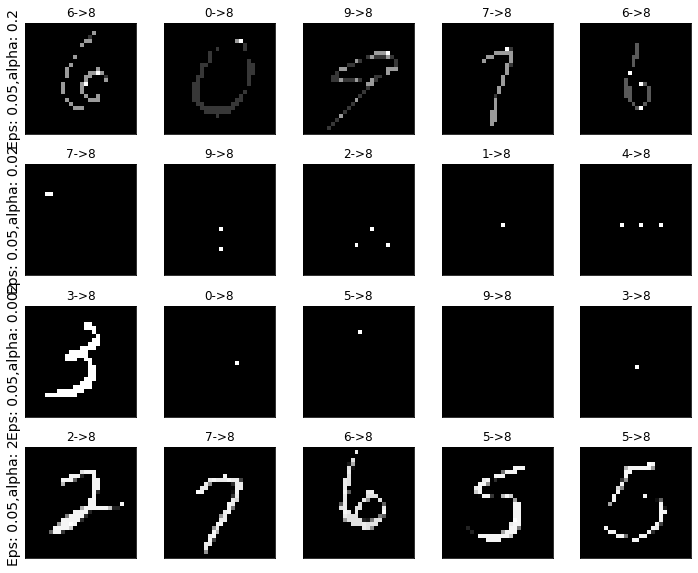

In [77]:
sample_viewer(examples_005,eps_alp_005)

## Epsilon = 0.5

In [79]:
eps_alp_05 = [(0.5,0.2),(0.5,0.4),(0.5,0.7),(0.5,1)]
acc_05,examples_05 = testing_samples(eps_alp_05)

Epsilon: 0.5	Alpha: 0.2	Test Accuracy = 2003 / 10000 = 0.2003
Epsilon: 0.5	Alpha: 0.4	Test Accuracy = 6667 / 10000 = 0.6667
Epsilon: 0.5	Alpha: 0.7	Test Accuracy = 9286 / 10000 = 0.9286
Epsilon: 0.5	Alpha: 1	Test Accuracy = 9644 / 10000 = 0.9644


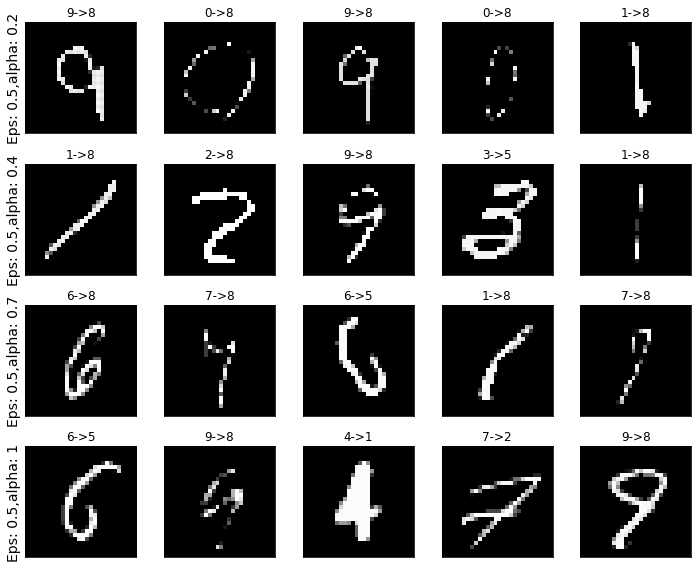

In [80]:
sample_viewer(examples_05,eps_alp_05)

## Adversarial Training using epsilon = 0.5 and alpha = 0.4 perturbations.

In [120]:
def train(epoch,epsilon, alpha_star):
    
    print('\n[ Train epoch: %d ]' % epoch)
    adv_model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for idx, (x, y,) in enumerate(train_loader):
        
        x_adv = perturb_new(epsilon, alpha_star,data=x,target=y)
        optimiser.zero_grad()
        y_pred = adv_model(x_adv)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimiser.step()
        train_loss += loss.item()
        _, predicted = y_pred.max(1)

        total += y.size(0)
        correct += predicted.eq(y).sum().item()        

        if idx % 1000 == 0:
            print('\nCurrent batch:', str(idx))
            print('Current adversarial train accuracy:', str(predicted.eq(y).sum().item() / y.size(0)))
            print('Current adversarial train loss:', loss.item())        
    print('\nTotal adversarial train accuarcy:', 100. * correct / total)
    print('Total adversarial train loss:', train_loss)

In [130]:
train_loader = torch.utils.data.DataLoader(datasets.MNIST('data', train=True,
                       transform=transforms.Compose([transforms.ToTensor(),]),
                       download=False),batch_size=10,shuffle=True,num_workers=4)

adv_model = Net().to(device)
epsilon=0.5
alpha_star=0.4
optimiser = optim.SGD(model.parameters(), lr=0.1)

In [131]:
accuracies = []
examples = []
file_name = 'adversarial_training'
for epoch in range(0, 50):
    train(epoch,epsilon, alpha_star)
    acc, ex = test(adv_model, device, epoch, epsilon, alpha_star)
    accuracies.append(acc)
    examples.append(ex)


[ Train epoch: 0 ]

Current batch: 0
Current adversarial train accuracy: 0.0
Current adversarial train loss: 23.60148048400879

Current batch: 1000
Current adversarial train accuracy: 0.1
Current adversarial train loss: 22.849777221679688


KeyboardInterrupt: 